In [1]:
%matplotlib inline

In [2]:
from tqdm import tqdm_notebook as tqdm
import corner
import pymc3 as pm
import theano.tensor as tt

import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo
import astropy.units as u

from astropy.stats import LombScargle

In [20]:
from lightkurve import search_lightcurvefile

def get_lightcurve(target, **kwargs):
    lc_collection = search_lightcurvefile(target, **kwargs).download_all(quality_bitmask="hardest")
    
    lc = lc_collection[0].PDCSAP_FLUX.normalize()
    for l in lc_collection[1:]:
        lc = lc.append(l.PDCSAP_FLUX.normalize())
    lc = lc.remove_outliers()

    lc = lc.remove_nans()
    magnitude = -2.5 * np.log10(lc.flux)
    magnitude = magnitude - np.average(magnitude)
    return lc.time, magnitude

#time, mag = get_lightcurve('KIC 6780873', cadence='long')
#time, mag = get_lightcurve('KIC 9651065', cadence='long')
time, mag = get_lightcurve('KIC 7917485', cadence='long')

#time = time[:5000]
#mag = mag[:5000]
#time = time[:-1000]
#mag = mag[:-1000]
#time = time[1000:8000]
#mag = mag[1000:8000]
time -= np.mean(time)
mag *= 1000

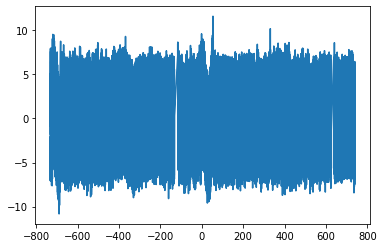

In [21]:
plt.plot(time, mag)

In [22]:
def estimate_frequencies(x, y, max_peaks=9, oversample=4.0, fmin=None, fmax=None):
    tmax = x.max()
    tmin = x.min()
    dt = np.median(np.diff(x))
    df = 1.0 / (tmax - tmin)
    ny = 0.5 / dt

    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = ny

    freq = np.arange(fmin, fmax, df / oversample)
    power = LombScargle(x, y).power(freq)

    # Find peaks
    peak_inds = (power[1:-1] > power[:-2]) & (power[1:-1] > power[2:])
    peak_inds = np.arange(1, len(power)-1)[peak_inds]
    peak_inds = peak_inds[np.argsort(power[peak_inds])][::-1]
    peaks = []
    for j in range(max_peaks):
        i = peak_inds[0]
        freq0 = freq[i]
        alias = 2.0*ny - freq0

        m = np.abs(freq[peak_inds] - alias) > 25*df
        m &= np.abs(freq[peak_inds] - freq0) > 25*df

        peak_inds = peak_inds[m]
        peaks.append(freq0)
    peaks = np.array(peaks)

    with pm.Model():
        nu = pm.Bound(pm.Normal, lower=fmin, upper=fmax)("nu", mu=peaks, sd=10, testval=peaks, shape=peaks.shape)
        arg = 2*np.pi*nu[None, :]*x[:, None]
        D = tt.concatenate((tt.cos(arg), tt.sin(arg), tt.ones((len(x), 1))), axis=1)
        DTD = tt.dot(D.T, D)
        DTy = tt.dot(D.T, y)
        w = tt.slinalg.solve(DTD, DTy)
        mod = tt.dot(D, w)
        pm.Normal("obs", mu=mod, observed=y)
        map_soln = xo.optimize()
    
    plt.plot(freq, power)
    plt.xlim(fmin, fmax)
    for n in map_soln["nu"]:
        plt.axvline(n, color="k", alpha=0.1, lw=2)
    
    return map_soln["nu"]

optimizing logp for variables: ['nu_interval__']
message: Desired error not necessarily achieved due to precision loss.
logp: -79369.18890665624 -> -75427.2400933581


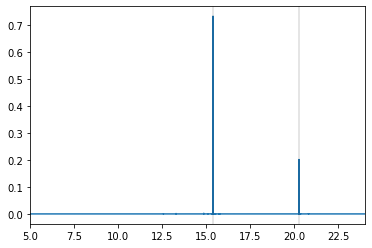

In [23]:
freq = estimate_frequencies(time, mag, max_peaks=2, fmin=5, fmax=1/(1/24))

In [115]:
from tqdm import tqdm_notebook as tqdm



with pm.Model() as simple_model:
    
    period = pm.Flat("period", testval=10.0)
    nu = pm.Flat("nu", testval=15)
    
    phi = xo.distributions.Angle("phi")
    logasini = pm.Uniform("logasini", lower=np.log(1), upper=np.log(1000),
                          testval=np.log(10))
    drift = pm.Normal("drift", mu=0, sd=1.0)
    
    M = 2.0 * np.pi * time / period - phi
    
    factor = 2. * np.pi * nu
    A = factor * (1 + drift) * time
    B = -factor * (tt.exp(logasini) / 86400) * tt.sin(M)
    
    sinarg = tt.sin(A+B)
    cosarg = tt.cos(A+B)
    
    DT = tt.stack((sinarg, cosarg, tt.ones_like(sinarg)))
    w = tt.slinalg.solve(tt.dot(DT, DT.T), tt.dot(DT, mag))
    pm.Deterministic("w", w)
    pm.Deterministic("phase", tt.arctan2(w[1], w[0]))
    lc_model = tt.dot(DT.T, w)
        
    pm.Normal("obs", mu=lc_model, observed=mag)
    
    fit_params = [v for v in simple_model.vars if v.name not in ["period", "nu"]]

def run_fit(p, nu):
    with simple_model:
        start = dict(simple_model.test_point)
        start["period"] = p
        start["nu"] = nu
        point, info = xo.optimize(start, vars=fit_params, return_info=True, verbose=False)
    return -info.fun, point

#periods = np.exp(np.linspace(np.log(10), np.log(25), 50))
periods = np.linspace(8,20, 50)
results = []
for f in freq:
    results.append([run_fit(p, f) for p in tqdm(periods)])

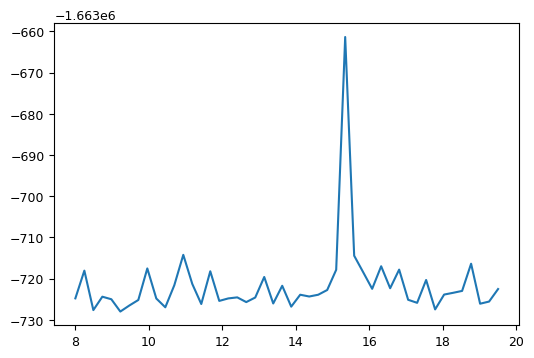

In [116]:
ys = np.array([[r[0] for r in row] for row in results])
sm = np.sum(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], sm[:-2]);

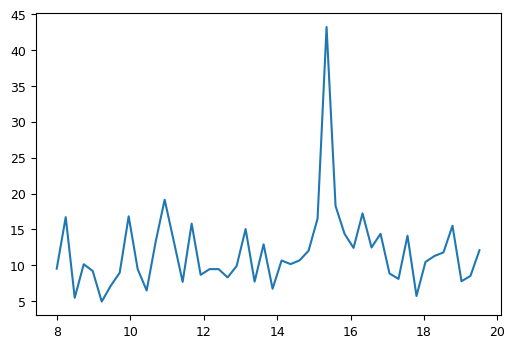

In [155]:
ys = np.array([[np.exp(r[1]["logasini"]) for r in row] for row in results])
sm = np.mean(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], sm[:-2]);

In [156]:
period_guess = periods[period_ind]
a_guess = np.max(sm)
period_guess, a_guess


(15.346938775510203, 43.249223344787794)

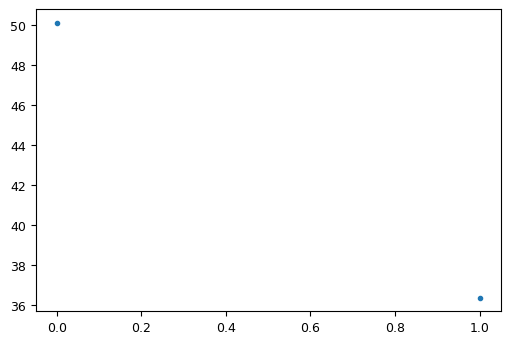

In [157]:
logasinis = np.array([[np.exp(r[1]["logasini"]) for r in row] for row in results])
# mu = np.median(logasinis, axis=1)
# sd = np.sqrt(np.median((logasinis - mu)**2, axis=1))
plt.plot(logasinis[:, period_ind], ".")

In [120]:
freq

array([13.94758984, 15.68332674])

In [7]:
def get_phase(nu, t, y):
    arg = 2*np.pi*nu[None, :]*t[:, None]
    D = np.concatenate((np.sin(arg), np.cos(arg),
                        np.ones((len(t), 1))), axis=1)
    DT = D.T
    DTD = np.dot(DT, D)
    w = np.linalg.solve(DTD, np.dot(D.T, y))
    return np.arctan2(w[:len(nu)], w[len(nu):2*len(nu)]) / (2*np.pi*nu)

In [8]:
get_phase(freq, time, mag)

array([-0.0105829,  0.0170929])

In [9]:
len(freq)

2

In [49]:
import tqdm
t0s = np.arange(time.min(), time.max(), 5.5)
phases = np.empty((len(t0s)-1, len(freq)))
phases[:] = np.nan
for i, t0 in tqdm.tqdm(enumerate(t0s[:-1]), total=len(t0s)-1):
    m = (t0 <= time) & (time < t0s[i+1])
    if m.sum() < 100:
        continue
    phases[i] = get_phase(freq, time[m], mag[m])
    
# phases -= np.nanmean(phases, axis=0)
full = np.mean(phases, axis=1)

100%|██████████| 267/267 [00:00<00:00, 4039.94it/s]


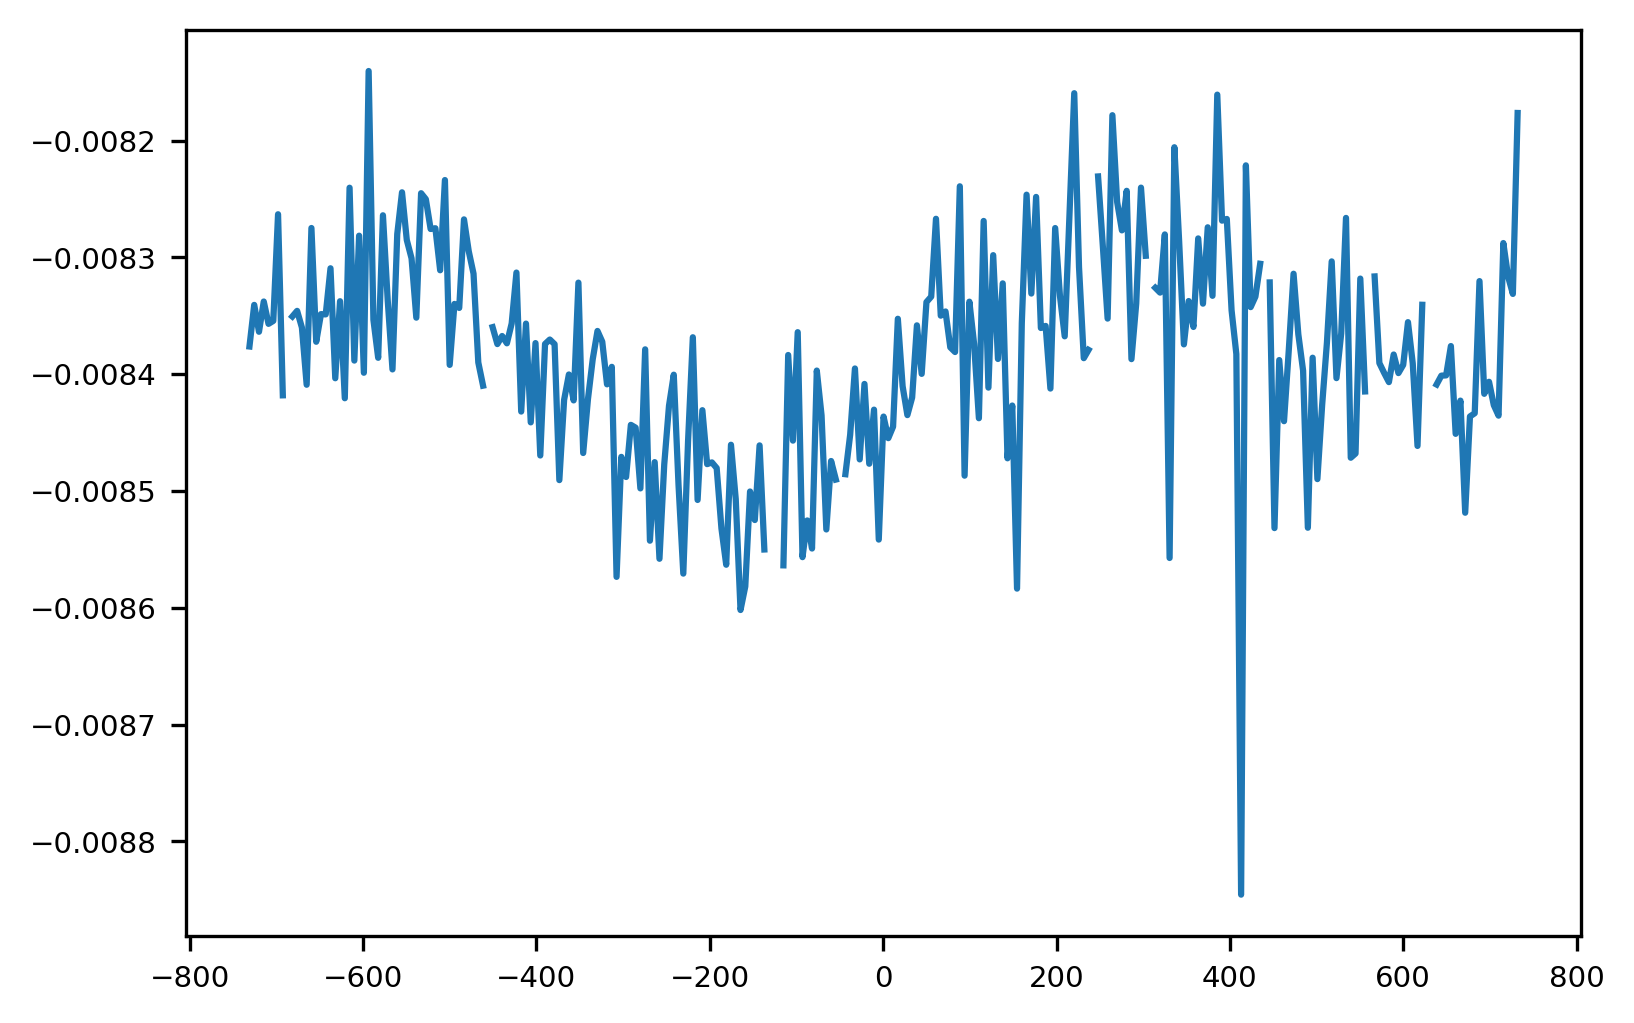

In [50]:
#plt.plot(t0s[:-1], phases)
plt.plot(t0s[:-1], full);

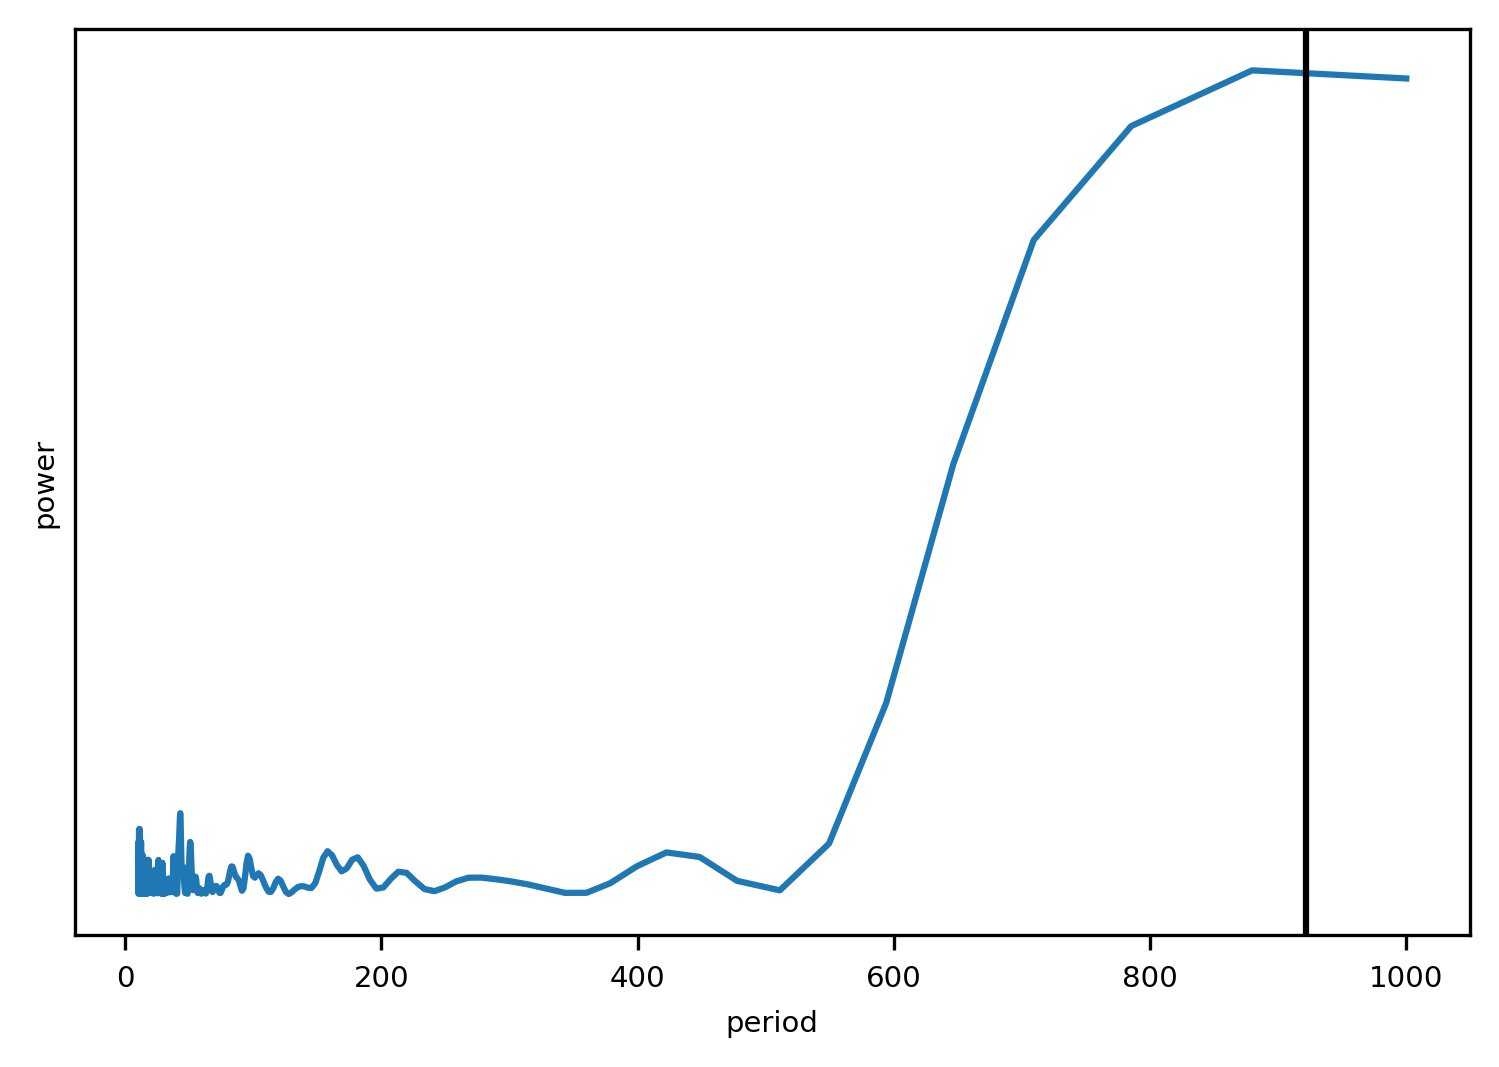

In [37]:
m = np.isfinite(phases[:, 0])
res = xo.estimators.lomb_scargle_estimator(t0s[:-1][m], full[m], min_period=10, max_period=1000)
f, p = res["periodogram"]
plt.plot(1 / f, p)
plt.axvline(res["peaks"][0]["period"], color="k")
plt.xlabel("period")
plt.ylabel("power")
plt.yticks([]);

In [30]:
%run setup.py

<Figure size 1800x1200 with 0 Axes>

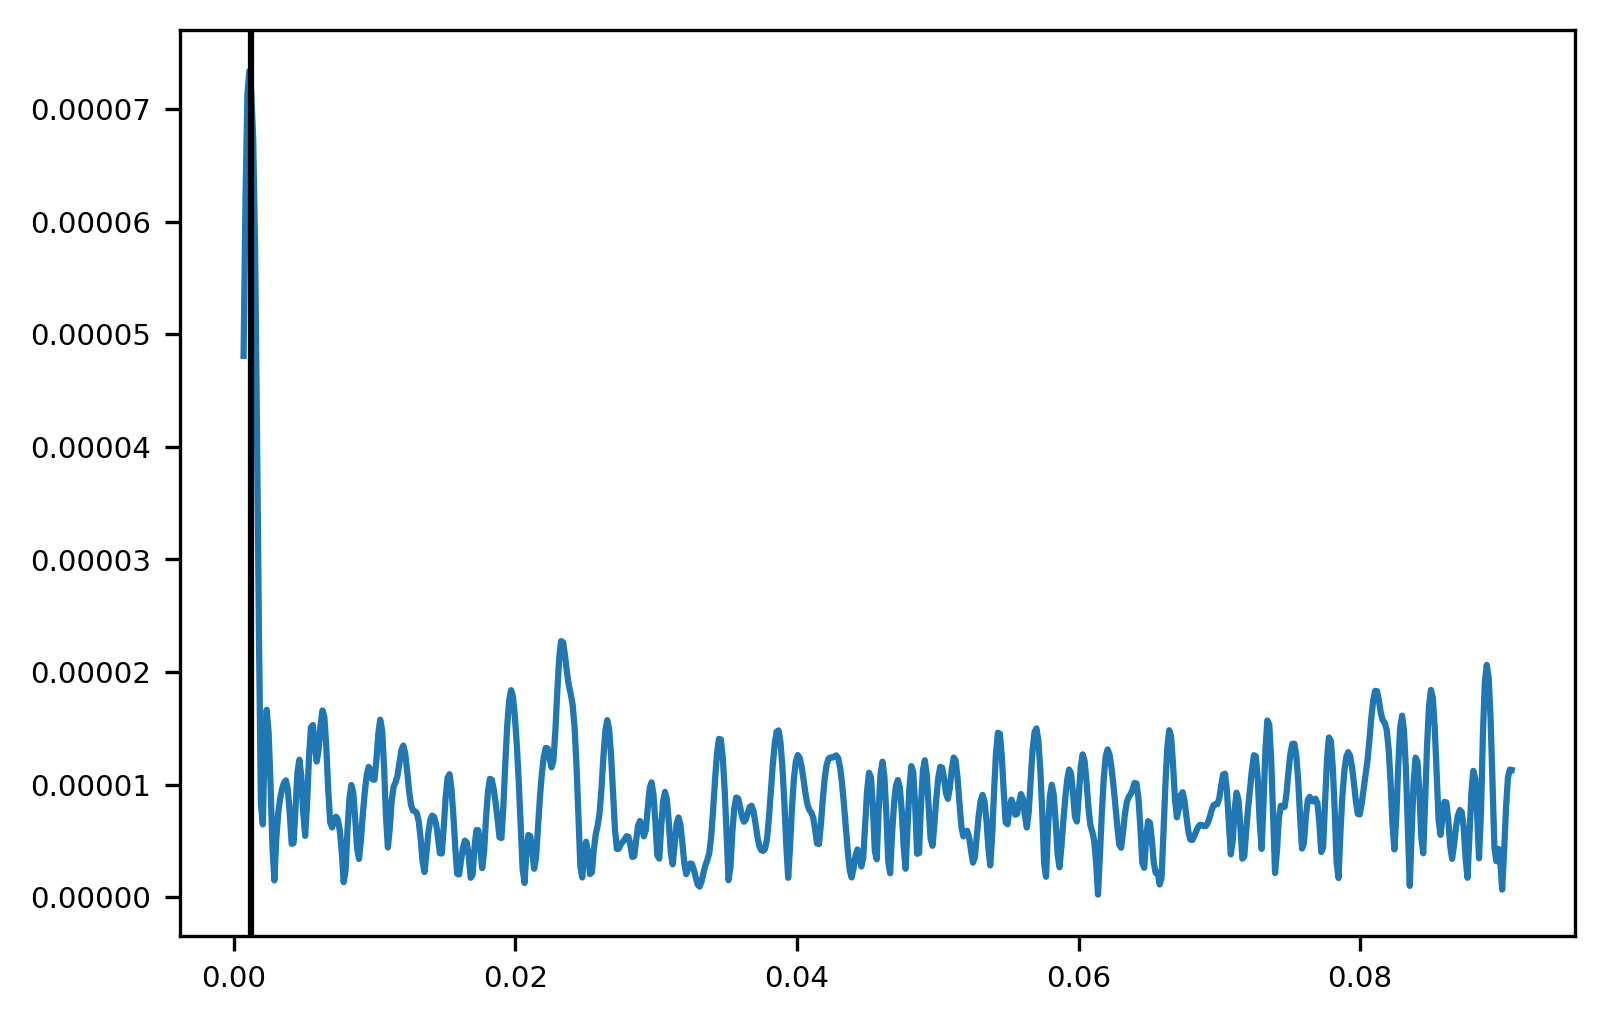

In [40]:
f, p = amp_spectrum(t0s[:-1][m], full[m])
plt.plot(f,p)
plt.axvline(1/846, c='black')

In [42]:
period_guess = 846#res["peaks"][0]["period"]
arg = 2*np.pi*t0s[:-1][m]/period_guess
D = np.concatenate((np.sin(arg)[:, None],
                    np.cos(arg)[:, None],
                    np.ones((len(phases[m]), 1))), axis=-1)
w = np.linalg.solve(np.dot(D.T, D), np.dot(D.T, phases[m, 0]))
a_guess = np.sqrt(np.sum(w[:2]**2)) * 86400
period_guess, a_guess 

(846, 6.6187127131229575)

In [39]:
a_guess

6.589814377213807

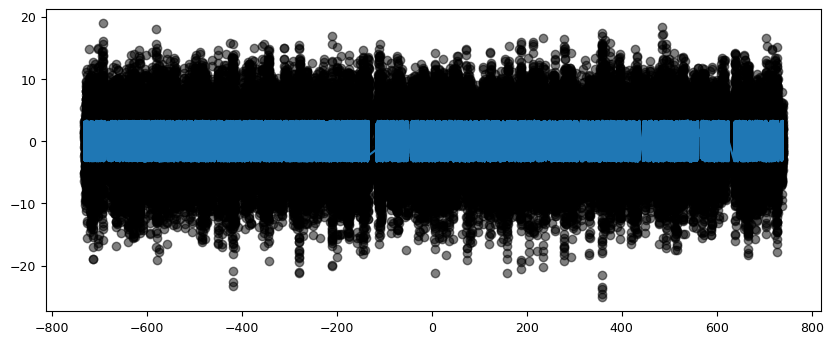

In [158]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt

with pm.Model() as model:
    # It's much faster to sample from a log-space period
#     logP = pm.Normal("logP", mu=np.log(9.15), sd=3.)
    logP = pm.Bound(pm.Normal,
                    lower=np.log(10),
                    upper=np.log(100))("logP", mu=np.log(period_guess), sd=1.0,
                                      testval=np.log(period_guess))
    period = pm.Deterministic("period", pm.math.exp(logP))
    # Time delay drift
    drift_gradient = 0.0
#     drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=0.01, shape=len(freq))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(mag)), sd=10, testval=-7.78585661)
    logasini = pm.Bound(pm.Normal,
                        lower=np.log(10),
                        upper=np.log(1000))('logasini', mu=np.log(a_guess), sd=10,
                                            testval=np.log(a_guess))
    asini = pm.Deterministic("asini", tt.exp(logasini))
        
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=-1.03171101)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.5)
    
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(time)))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    
    # Sampling in the weights parameter is faster than solving the matrix.
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    
    arg = ((factor * (1 - drift_gradient))[None, :] * time[:, None]
           - (factor * asini / 86400)[None, :] * psi[:, None])
    
#     W_hat_cos = pm.Normal("W_hat_cos", mu=0.0, sd=0.01, shape=len(freq))
#     W_hat_sin = pm.Normal("W_hat_sin", mu=0.0, sd=0.01, shape=len(freq))
#     model_tensor = tt.dot(tt.cos(arg), W_hat_cos[:, None])
#     model_tensor += tt.dot(tt.sin(arg), W_hat_sin[:, None])
#     lc_model = tt.squeeze(model_tensor)

    phase = xo.distributions.Angle("phase", shape=len(freq))
    log_min_amp = np.log(0.1 * np.std(mag))  # np.log(np.median(np.abs(np.diff(mag))))
    log_max_amp = np.log(np.std(mag))
    log_mean_amp = 0.5*(log_min_amp + log_max_amp)
    logamp = pm.Bound(pm.Normal,
                      lower=log_min_amp,
                      upper=log_max_amp)("logamp", mu=log_mean_amp, sd=10.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
        
    # GP parameters
    logw0 = pm.Bound(pm.Normal,
                     lower=np.log(2*np.pi/100.0),
                     upper=np.log(2*np.pi/2.0))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(mag)), sd=10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean
#     pm.Normal("obs", mu=full_lc, sd=tt.exp(logs_lc), observed=mag)

#     mag_sim = xo.eval_in_model(full_lc) + np.median(np.abs(np.diff(mag))) * np.random.randn(len(time))

    pm.Potential("obs", gp.log_likelihood(mag - full_lc))
#     pm.Deterministic("gp_pred", gp.predict())


    
fig, axes = plt.subplots(1,1, figsize=[10,4])
with model:
    
    ax = axes
    lc_l = xo.eval_in_model(lc_model)
    ax.plot(time, lc_l)
    plt.scatter(time,mag, c='black', alpha=0.5)

In [159]:
import theano

with model:
    func = xo.utils.get_theano_function_for_var(model.logpt, profile=True)
#     func = xo.utils.get_theano_function_for_var(theano.grad(model.logpt, model.vars), profile=True)
    args = xo.utils.get_args_for_theano_function(model.test_point)
    print(func(*args))
    
    %timeit func(*args)
    

-5349643254.789775
17.2 ms ± 983 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
func.profile.summary()

Function profiling
  Message: /Users/dforeman/research/projects/dfm/exoplanet/exoplanet/utils.py:30
  Time in 8112 calls to Function.__call__: 1.327107e+01s
  Time in Function.fn.__call__: 1.291495e+01s (97.317%)
  Time in thunks: 1.232395e+01s (92.863%)
  Total compile time: 1.909515e+00s
    Number of Apply nodes: 131
    Theano Optimizer time: 9.832051e-01s
       Theano validate time: 2.704024e-02s
    Theano Linker time (includes C, CUDA code generation/compiling): 6.845350e-01s
       Import time 4.042101e-01s
       Node make_thunk time 6.798708e-01s
           Node Elemwise{Composite{(i0 * (i1 + (i2 * sqr((i3 + i4)))))}}(TensorConstant{0.5}, TensorConstant{-6.443047252397437}, TensorConstant{-0.01}, TensorConstant{-3.315232515335083}, logpower) time 4.280090e-02s
           Node Elemwise{Composite{((i0 * i1) + (i2 * i3))}}(InplaceDimShuffle{x,0}.0, Elemwise{cos,no_inplace}.0, InplaceDimShuffle{x,0}.0, Elemwise{Sin}[(0, 0)].0) time 3.583002e-02s
           Node Elemwise{Composit

In [160]:
model.vars

[logP_interval__,
 phi_angle__,
 logs_lc,
 logasini_interval__,
 omega_angle__,
 eccen_interval__,
 mean,
 lognu,
 phase_angle__,
 logamp_interval__,
 logw0_interval__,
 logpower]

[phi_angle__, logs_lc, omega_angle__, eccen_interval__, mean, lognu, phase_angle__, logamp_interval__, logw0_interval__, logpower]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -5349643254.789775 -> -5349643252.69162
optimizing logp for variables: ['logs_lc']
message: Optimization terminated successfully.
logp: -5349643252.69162 -> -186091.71633986416
optimizing logp for variables: ['logw0_interval__', 'logpower']
message: Optimization terminated successfully.
logp: -186091.71633986416 -> -172307.29605086183
optimizing logp for variables: ['logamp_interval__', 'phase_angle__']
message: Optimization terminated successfully.
logp: -172307.29605086183 -> -169301.15354095484
optimizing logp for variables: ['omega_angle__', 'eccen_interval__']
message: Desired error not necessarily achieved due to precision loss.
logp: -169301.15354095484 -> -169279.6159644479
optimizing logp for variables: ['phi_angle__']
message: Desired error not necessarily

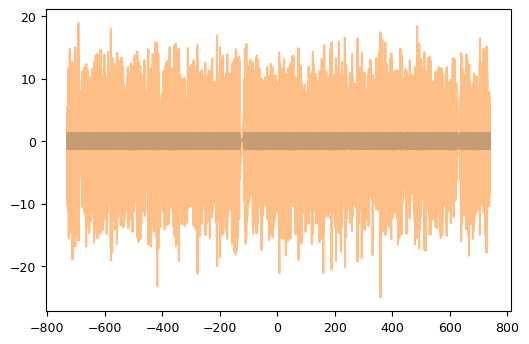

In [161]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[phase, logamp])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

#     map_params = xo.optimize(start=map_params)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, mag, alpha=0.5)

In [162]:
map_params

{'logP_interval__': array(-1.47606997),
 'phi_angle__': array([0.99798332, 1.00980093]),
 'logs_lc': array(0.7844762),
 'logasini_interval__': array(-0.76051324),
 'omega_angle__': array([-3.85091964,  2.3356958 ]),
 'eccen_interval__': array(0.23003947),
 'mean': array(0.01326922),
 'lognu': array([2.63534678, 2.75263712]),
 'phase_angle__': array([[ 4.44244454, -3.53864091],
        [-0.26087487, -2.74161387]]),
 'logamp_interval__': array([-1.95913279, -2.4442736 ]),
 'logw0_interval__': array(9.2166735),
 'logpower': array(8.72395886),
 'logP': array(2.73091603),
 'period': array(15.34693877),
 'phi': array(0.77951233),
 'logasini': array(3.76949227),
 'asini': array(43.35804507),
 'omega': array(-1.02558966),
 'eccen': array(0.50153183),
 'nu': array([13.94814852, 15.68393779]),
 'phase': array([ 1.62945224, -2.22995934]),
 'logamp': array([-0.37064206, -0.47127105]),
 'logw0': array(1.14434119),
 'logS0': array(4.14659409)}

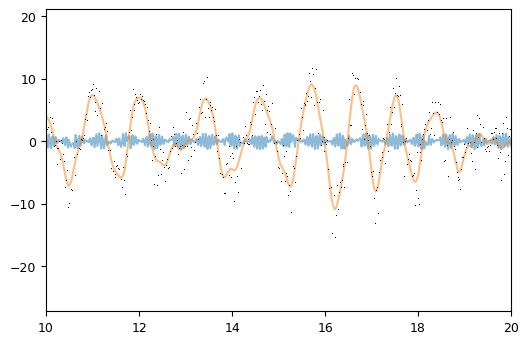

In [163]:
with model:
    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, xo.eval_in_model(gp.predict(), map_params), alpha=0.5)
    plt.plot(time, mag, ",k")
    plt.xlim(10,20)

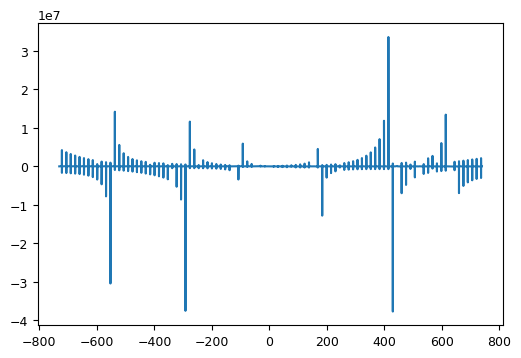

In [167]:
with model:
    plt.plot(time, xo.eval_in_model(asini * psi, map_params))
    #plt.xlim(0, 50)

In [25]:
sampler = xo.PyMC3Sampler(window=200, finish=500)
with model:
    burnin = sampler.tune(tune=2000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 2 chains: 100%|██████████| 1004/1004 [02:33<00:00,  1.99draws/s]


In [26]:
with model:
    trace = sampler.sample(draws=2000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logpower, logw0, logamp, phase, lognu, mean, eccen, omega, logasini, logs_lc, phi, logP]
Sampling 2 chains: 100%|██████████| 4000/4000 [10:05<00:00,  3.87draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [27]:
pm.summary(trace)

mean         sd      mc_error    hpd_2.5   hpd_97.5  \
logs_lc     0.360798   0.013108  1.965545e-04   0.333914   0.385243   
mean        0.160745   1.595231  2.166214e-02  -2.986237   3.171642   
lognu__0    2.635308   0.000010  1.277795e-07   2.635289   2.635328   
lognu__1    2.752599   0.000009  1.112757e-07   2.752582   2.752615   
lognu__2    2.521938   0.000015  2.151045e-07   2.521908   2.521965   
logpower    9.234542   0.059360  8.096740e-04   9.118388   9.351229   
logP        3.107544   0.379404  1.199981e-02   2.303466   3.718520   
period     23.965858   8.739806  2.659377e-01  10.002144  41.186369   
phi        -0.006992   1.831262  4.321148e-02  -2.909380   3.027227   
logasini    3.153704   0.567932  1.775000e-02   2.304163   4.157308   
asini      27.782090  17.885678  5.458356e-01  10.003551  63.834366   
omega      -0.079173   1.838045  4.780108e-02  -3.132697   2.829470   
eccen       0.467688   0.263897  4.320731e-03   0.044869   0.896579   
nu__0      13.947614   0.000137  1.782221e-06  13.947340  13.947883   
nu__1      15.683334   0.000134  1.745178e-06  15.683081  15.683587   
nu__2      12.452703   0.000182  2.678634e-06  12.452329  12.453046   
phase__0   -1.000724   0.029192  6.396024e-04  -1.059242  -0.942658   
phase__1    1.192546   0.030959  6.879055e-04   1.130362   1.254133   
phase__2   -1.170578   0.036403  6.138433e-04  -1.239783  -1.096604   
logamp__0   0.381021   0.021331  2.681729e-04   0.338946   0.420953   
logamp__1   0.382926   0.022545  2.965019e-04   0.337781   0.425736   
logamp__2   0.019547   0.030401  3.973577e-04  -0.038734   0.080254   
logw0       1.138731   0.005874  8.390609e-05   1.126844   1.144722   
logS0       4.679618   0.063224  8.726446e-04   4.550149   4.800838   

                 n_eff      Rhat  
logs_lc    5368.641996  1.000194  
mean       6280.298171  0.999949  
lognu__0   5266.605330  0.999920  
lognu__1   5898.419028  0.999795  
lognu__2   6074.692692  0.999851  
logpower   5054.734943  1.000305  
logP        926.248150  1.000110  
period     1032.315757  1.000408  
phi        1726.571361  1.000211  
logasini   1084.662232  1.000752  
asini      1077.105688  1.000259  
omega      1455.897914  0.999846  
eccen      3696.242457  1.000091  
nu__0      5266.603958  0.999920  
nu__1      5898.414634  0.999795  
nu__2      6074.687635  0.999851  
phase__0   2044.458619  0.999756  
phase__1   1966.477283  0.999949  
phase__2   3089.424077  0.999751  
logamp__0  6054.618928  0.999986  
logamp__1  4963.982845  0.999751  
logamp__2  6255.575884  0.999792  
logw0      5166.046875  0.999933  
logS0      5197.223835  1.000042

In [28]:
model.vars

[logP_interval__,
 phi_angle__,
 logs_lc,
 logasini_interval__,
 omega_angle__,
 eccen_interval__,
 mean,
 lognu,
 phase_angle__,
 logamp_interval__,
 logw0_interval__,
 logpower]

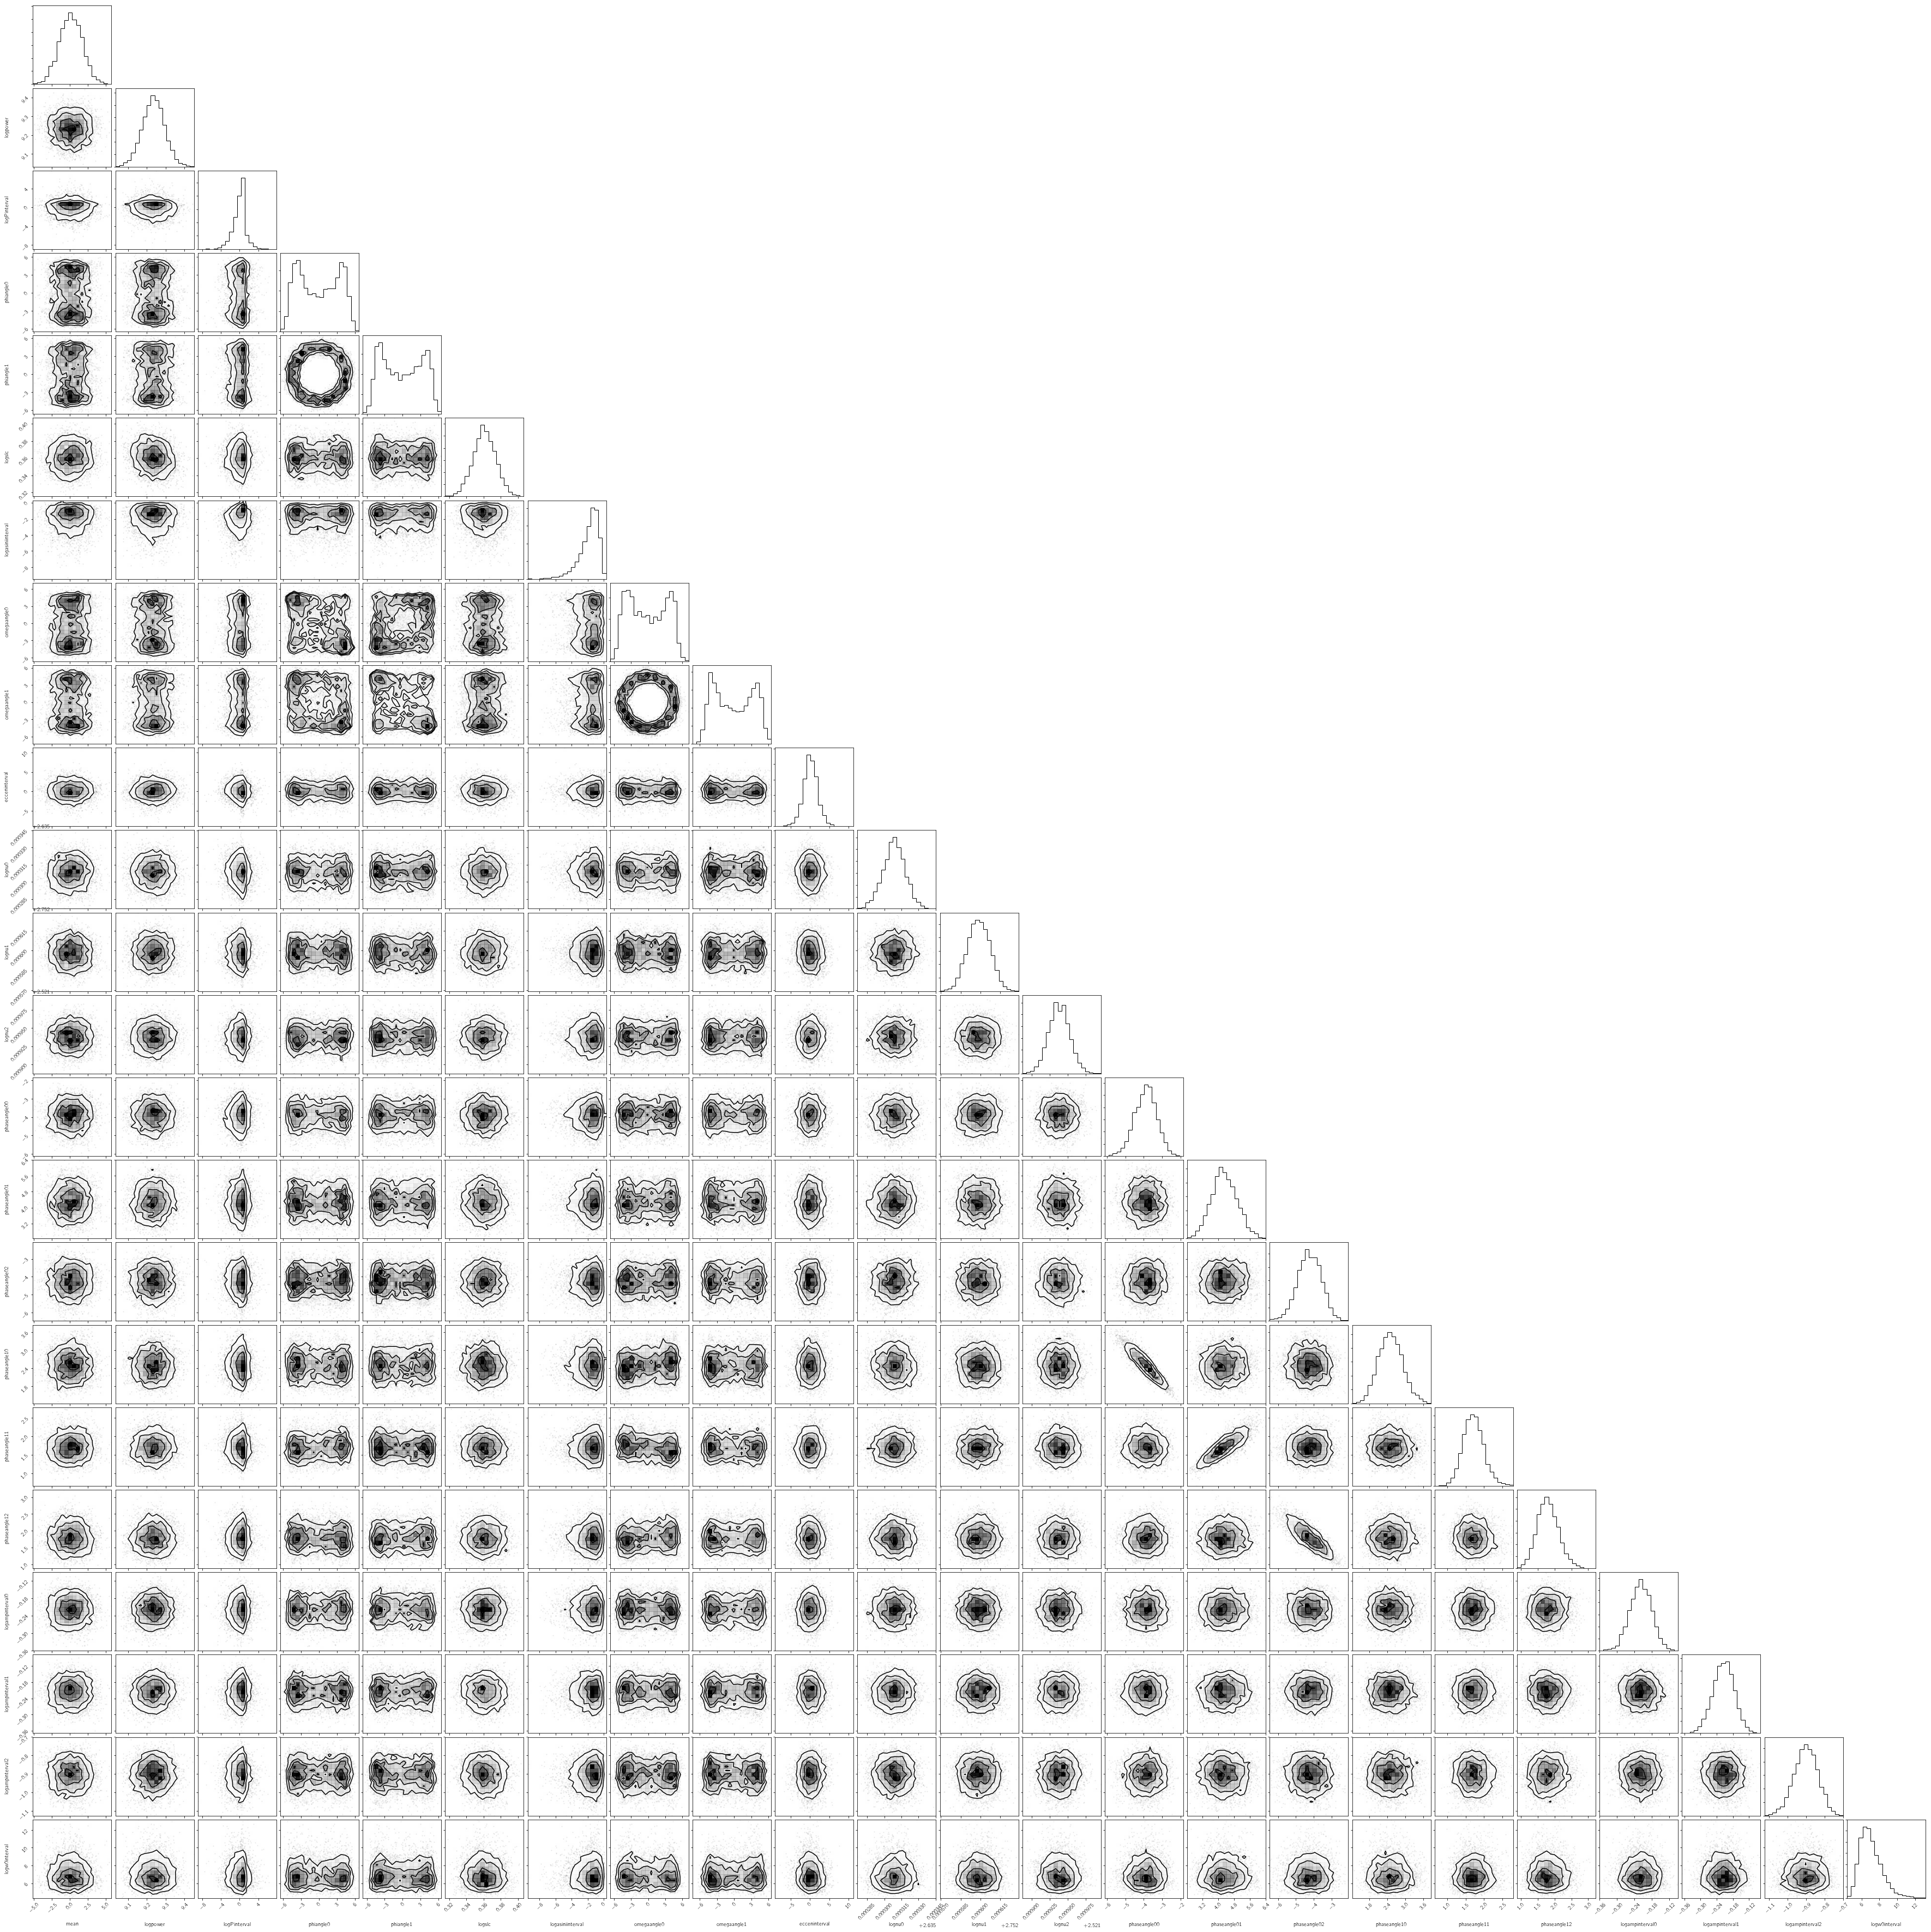

In [29]:
samples = pm.trace_to_dataframe(trace, varnames=[v.name for v in model.vars])
for k in samples.columns:
    if "_" in k:
        samples[k.replace("_", "")] = samples[k]
        del samples[k]
corner.corner(samples);

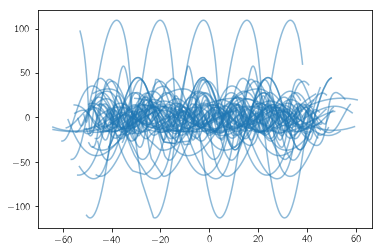

In [30]:
with model:
    for samp in xo.utils.get_samples_from_trace(trace, size=50):
        plt.plot(time + xo.eval_in_model(phi * period / (2*np.pi), samp), xo.eval_in_model(asini * psi, samp), color="C0", alpha=0.5)
#     plt.xlim(0, 50)

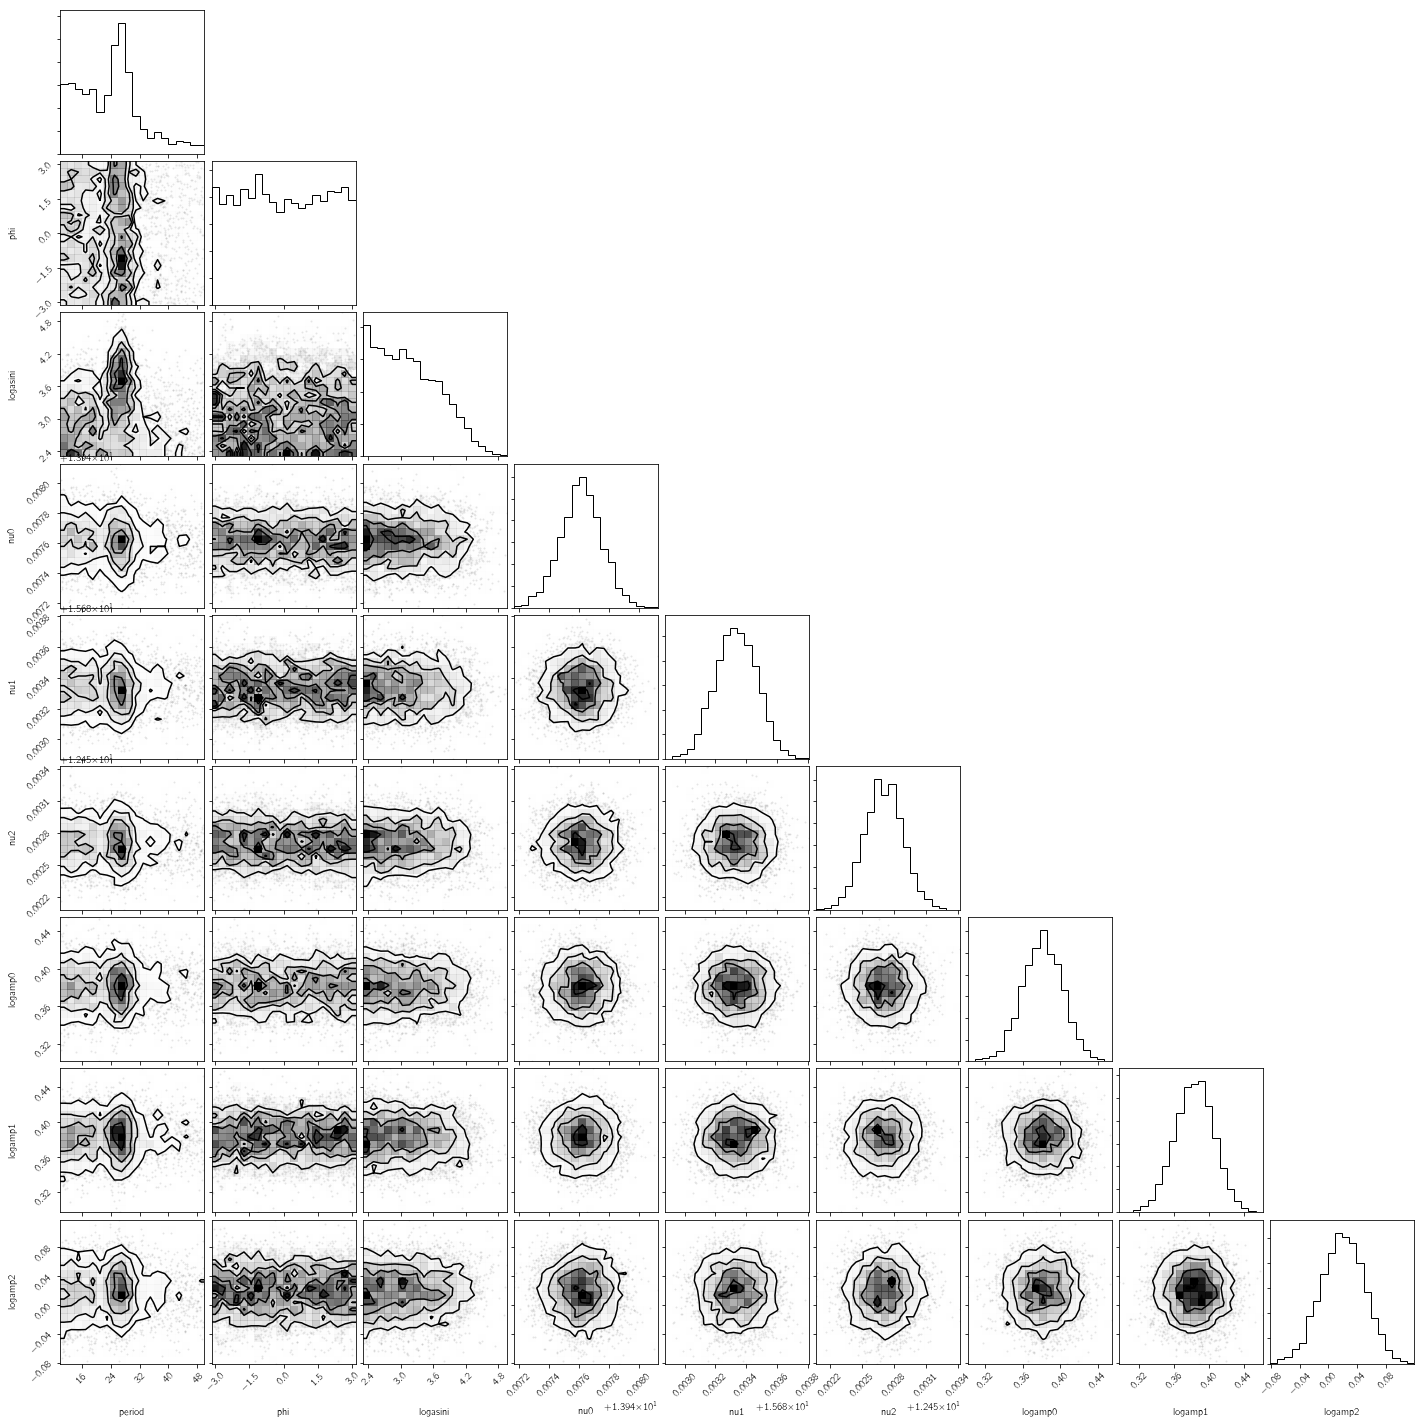

In [33]:
samples = pm.trace_to_dataframe(trace, varnames=["period", "phi", "logasini", "nu", "logamp"])
for k in samples.columns:
    if "_" in k:
        samples[k.replace("_", "")] = samples[k]
        del samples[k]
corner.corner(samples);

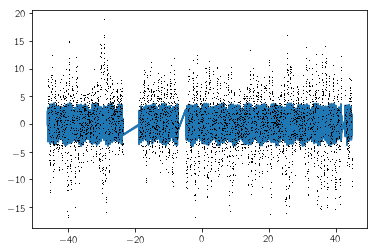

In [32]:
with model:
    for samp in xo.utils.get_samples_from_trace(trace, size=50):
        plt.plot(time, xo.eval_in_model(lc_model, samp), color="C0", alpha=0.1)
    plt.plot(time, mag, ",k")
#     plt.xlim(0, 50)